In [1]:
DATE = "2021-08-25"
TASK = "k-medoids-error-cluster-detection-multi-entity-graph-aligner-test"
DIR = mkpath("$(homedir())/$(DATE)-$(TASK)")

"/home/jovyan/2021-08-25-k-medoids-error-cluster-detection-multi-entity-graph-aligner-test"

In [2]:
import Pkg
pkgs = [
#     "BioAlignments",
    "BioSequences",
    "Clustering",
#     "CodecZlib",
#     "Colors",
#     "Combinatorics",
    "DataFrames",
#     "DataStructures",
    "Dates",
#     "DelimitedFiles",
    "Distances",
#     "EzXML",
    "FASTX",
#     "GFF3",
#     "HTTP",
#     "Impute",
#     "JSON",
    "LightGraphs",
    "LSHFunctions",
#     "Measures",
    "MetaGraphs",
    "https://github.com/cjprybol/Mycelia.git",
#     "NumericIO",
#     "PlotlyJS",
#     "Plots",
    "Primes",
#     "Printf",
    "ProgressMeter",
    "Random",
    "Revise",
    "SparseArrays",
    "Statistics",
    "StatsBase",
    "StatsPlots",
#     "StringDistances",
    "uCSV",
#     "XLSX",
]

unregistered_packages = filter(pkg -> occursin(r"(^https|git$)", pkg), pkgs)
registered_packages = setdiff(pkgs, unregistered_packages)

for pkg in registered_packages
    try
        eval(Meta.parse("import $(pkg)"))
    catch
        Pkg.add(pkg)
        Pkg.build(pkg)
        eval(Meta.parse("import $(pkg)"))
    end
end

for pkg_url in unregistered_packages
    pkg_name = replace(basename(pkg_url), ".git" => "")
    try
        eval(Meta.parse("import $(pkg_name)"))
    catch
        Pkg.develop(url=pkg_url)
        Pkg.build(pkg_name)
        eval(Meta.parse("import $(pkg_name)"))
    end
end

In [3]:
if Sys.isapple()
    BANDAGE = "/Applications/Bandage.app/Contents/MacOS/Bandage"
else
    BANDAGE = "Bandage"
end

"Bandage"

In [4]:
function assess_kmer_sparsity_in_reads(k, observations)
    canonical_kmer_counts = Mycelia.count_canonical_kmers(BioSequences.DNAMer{k}, observations)
    total_observed_canonical_kmers = length(keys(canonical_kmer_counts))
    total_possible_canonical_kmers = (4^k)/2
    sparsity = round(total_observed_canonical_kmers/total_possible_canonical_kmers*100, sigdigits=3)
    return sparsity
end

assess_kmer_sparsity_in_reads (generic function with 1 method)

In [5]:
function sequence_to_canonical_kmers(kmer_type, sequence)
    return (BioSequences.canonical(kmer.fw) for kmer in BioSequences.each(kmer_type, sequence))
end

sequence_to_canonical_kmers (generic function with 1 method)

In [6]:
function determine_edge_weights(graph)
    outgoing_edge_probabilities = determine_edge_weights(graph, true)
    incoming_edge_probabilities = determine_edge_weights(graph, false)
    return Dict(true => outgoing_edge_probabilities, false => incoming_edge_probabilities)
end

determine_edge_weights (generic function with 1 method)

In [7]:
function determine_edge_weights(graph, strand)
    kmers = [graph.vprops[v][:kmer] for v in LightGraphs.vertices(graph)]
    outgoing_edge_weights = SparseArrays.spzeros(length(kmers), length(kmers))
    
    for (kmer_index, kmer) in enumerate(kmers)
        if !strand
            kmer = BioSequences.reverse_complement(kmer)
        end
        
        downstream_neighbors = []
        downstream_neighbor_weights = []
        for neighbor in BioSequences.neighbors(kmer)
            canonical_neighbor = BioSequences.canonical(neighbor)
            neighbor_orientation = neighbor == canonical_neighbor
            
            neighbor_index_range = searchsorted(kmers, canonical_neighbor)
            if !isempty(neighbor_index_range)
                @assert length(neighbor_index_range) == 1
                neighbor_index = first(neighbor_index_range)
                if LightGraphs.has_edge(graph, LightGraphs.Edge(kmer_index, neighbor_index))
                    edge_orientations = graph.eprops[LightGraphs.Edge(kmer_index, neighbor_index)][:orientations]
                    this_edge_orientation = (source_orientation = strand, destination_orientation = neighbor_orientation)
                    if this_edge_orientation in edge_orientations
                        edge_weight = graph.eprops[LightGraphs.Edge(kmer_index, neighbor_index)][:weight]
                        outgoing_edge_weights[kmer_index, neighbor_index] = edge_weight
                    end
                end
            end
        end
    end
    return outgoing_edge_weights
end

determine_edge_weights (generic function with 2 methods)

In [8]:
function determine_edge_probabilities(edge_weights)
    edge_probabilities = deepcopy(edge_weights)
    for orientation in [true, false]
        for row in 1:size(edge_probabilities[orientation], 1)
            edge_weights = edge_probabilities[orientation][row, :]
            edge_total = sum(edge_weights)
            for (col, edge_weight) in enumerate(edge_weights)
                if edge_total > 0
                    edge_probabilities[orientation][row, col] = edge_weight/edge_total
                else
                    edge_probabilities[orientation][row, col] = 0.0
                end
            end
        end
    end
    return edge_probabilities
end

determine_edge_probabilities (generic function with 1 method)

In [9]:
function random_step(current_vertex, current_orientation, step_probabilities)
    outgoing_edge_likelihoods = step_probabilities[initial_orientation][current_vertex, :]
    chosen_step = StatsBase.sample(outgoing_edge_likelihoods.nzind, StatsBase.weights(outgoing_edge_likelihoods.nzval))
    possible_orientations = observation_graph.eprops[LightGraphs.Edge(current_vertex, chosen_step)][:orientations]
    possible_orientations = filter(o -> o.source_orientation == current_orientation, possible_orientations)
    chosen_orientation = rand(possible_orientations).destination_orientation
    chosen_oriented_step = (vertex = chosen_step, orientation = chosen_orientation)
    return chosen_oriented_step
end

random_step (generic function with 1 method)

In [10]:
function random_walk(observation_graph, initial_vertex, initial_orientation, step_probabilities; n_steps=size(step_probabilities[true], 1))
    step_count = 0
    outgoing_edge_likelihoods = step_probabilities[initial_orientation][initial_vertex, :]
    walk = Vector{NamedTuple{(:vertex, :orientation), Tuple{Int64, Bool}}}()
    done = (step_count >= n_steps) || (sum(outgoing_edge_likelihoods) == 0)
    current_vertex = initial_vertex
    current_orientation = initial_orientation
    while !done
#         @show "choosing"
        chosen_step = StatsBase.sample(outgoing_edge_likelihoods.nzind, StatsBase.weights(outgoing_edge_likelihoods.nzval))
        chosen_step
        possible_orientations = observation_graph.eprops[LightGraphs.Edge(current_vertex, chosen_step)][:orientations]
        possible_orientations
        current_orientation
        possible_orientations = filter(o -> o.source_orientation == current_orientation, possible_orientations)
        possible_orientations
        chosen_orientation = rand(possible_orientations).destination_orientation
        chosen_oriented_step = (vertex = chosen_step, orientation = chosen_orientation)
        push!(walk, chosen_oriented_step)
        current_vertex = chosen_step
        current_orientation = chosen_orientation
        outgoing_edge_likelihoods = step_probabilities[last(walk).orientation][last(walk).vertex, :]
        step_count += 1
#         @show outgoing_edge_likelihoods
        done = (step_count >= n_steps) || (sum(outgoing_edge_likelihoods) == 0)
    end
    return walk
end

random_walk (generic function with 1 method)

In [11]:
# km = vmax/2 = optimal number of reads
# slope is less than 10%?

In [12]:
# generate genomes
fasta_records = []
sequence_lengths = [100, 1000]
weights = [10, 1]
for (sequence_length, depth) in zip(sequence_lengths, weights)
    sequence = BioSequences.randdnaseq(Random.seed!(sequence_length), sequence_length)
    sequence_id = string(hash(sequence))
    description = string(depth)
    fasta_record = FASTX.FASTA.Record(sequence_id, description, sequence)
    push!(fasta_records, fasta_record)
end

In [13]:
file_basename = join(["L-$(length(FASTX.sequence(record)))" for record in fasta_records], '_')
reference_fasta_file = "$(DIR)/$(file_basename).fasta"
open(reference_fasta_file, "w") do io
    fastx_io = FASTX.FASTA.Writer(io)
    for fasta_record in fasta_records
        write(fastx_io, fasta_record)
    end
    close(fastx_io)
end

In [14]:
# randomly sample reads with errors from the genome
error_rate = 0.01
n_reads = 10_000

10000

In [15]:
observations = [Mycelia.observe(StatsBase.sample(fasta_records, StatsBase.Weights(weights)), error_rate = error_rate) for i in 1:n_reads];

In [16]:
# determine distribution of read lengths

In [17]:
sorted_read_lengths = sort(length.(FASTX.sequence.(observations)))

10000-element Vector{Int64}:
   96
   97
   97
   97
   97
   97
   97
   97
   97
   97
   97
   97
   97
    ⋮
 1005
 1006
 1006
 1006
 1006
 1006
 1006
 1006
 1006
 1006
 1007
 1008

In [18]:
first_percentile_read_length = sorted_read_lengths[Int(round(length(sorted_read_lengths) * .01))]

98

In [19]:
# determine optimal k
min_k = min(5, first_percentile_read_length)
max_k = min(61, first_percentile_read_length)
k_options = Primes.primes(min_k, max_k)
# sparsity_threshold = 0.01
# sparsity_threshold = 0.1
sparsity_threshold = 1
# sparsity_threshold = 10
k_index = nothing
for (i, k) in enumerate(k_options)
    sparsity = assess_kmer_sparsity_in_reads(k, observations)
    @show k, sparsity
    if sparsity < sparsity_threshold
        k_index = i
        break
    end
end
# k_index = findfirst(k -> assess_kmer_sparsity_in_reads(k, observations) <= sparsity_threshold, k_options)
if k_index == nothing
    k = k_options[end]
else
    k = k_options[k_index]
end
@show k

(k, sparsity) = (5, 100.0)
(k, sparsity) = (7, 97.3)
(k, sparsity) = (11, 2.58)
(k, sparsity) = (13, 0.201)
k = 13


13

In [20]:
observations_file = "$(DIR)/$(file_basename)-DEPTH-$(n_reads).fastq"
open(observations_file, "w") do io
    fastq_io = FASTX.FASTQ.Writer(io)
    for record in observations
        write(fastq_io, record)
    end
    close(fastq_io)
end

# Begin graph resolving of observation graph

In [21]:
# assess kmer counts

In [22]:
# fit linear trendline to kmer counts

In [23]:
# apply thresholding when constructing kmer graph at the trendline

In [27]:
kmer_counts = Mycelia.count_canonical_kmers(BioSequences.DNAMer{k}, observations_file)

OrderedCollections.OrderedDict{BioSequences.DNAMer{13}, Int64} with 67421 entries:
  AAAAAACTTATCA => 7
  AAAAAATACTGAA => 3
  AAAAAATTATCAC => 2
  AAAAAATTATCAT => 5
  AAAAACAATACAA => 1
  AAAAACAATTTAT => 5
  AAAAACATAGATG => 1
  AAAAACATTATCA => 1
  AAAAACCGGTCCA => 1
  AAAAACCTATCAC => 2
  AAAAACCTTATCA => 1
  AAAAACGCTGAGG => 6
  AAAAACGCTGGAG => 1
  AAAAACGTATCAC => 1
  AAAAACTAATCAC => 1
  AAAAACTATCACA => 9
  AAAAACTTAAACG => 3
  AAAAACTTAATCA => 2
  AAAAACTTACACA => 4
  AAAAACTTAGCAC => 1
  AAAAACTTAGTCA => 2
  AAAAACTTATAAC => 1
  AAAAACTTATACA => 1
  AAAAACTTATACC => 1
  AAAAACTTATCAA => 3
  ⋮             => ⋮

In [28]:
kmer_counts_histogram = sort(collect(StatsBase.countmap(values(kmer_counts))), by=x->x[1])

201-element Vector{Pair{Int64, Int64}}:
    1 => 34002
    2 => 12999
    3 => 6266
    4 => 3091
    5 => 1871
    6 => 1466
    7 => 1090
    8 => 951
    9 => 961
   10 => 617
   11 => 443
   12 => 374
   13 => 347
      ⋮
 8022 => 1
 8026 => 1
 8029 => 1
 8034 => 1
 8036 => 1
 8041 => 1
 8042 => 1
 8049 => 1
 8054 => 1
 8060 => 1
 8062 => 1
 8094 => 1

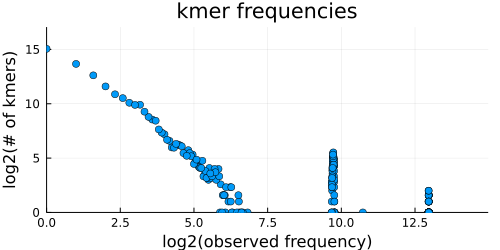

In [29]:
scale = 250
Mycelia.plot_kmer_frequency_spectra(values(kmer_counts), size=(2scale,scale), log_scale=log2, title="kmer frequencies")

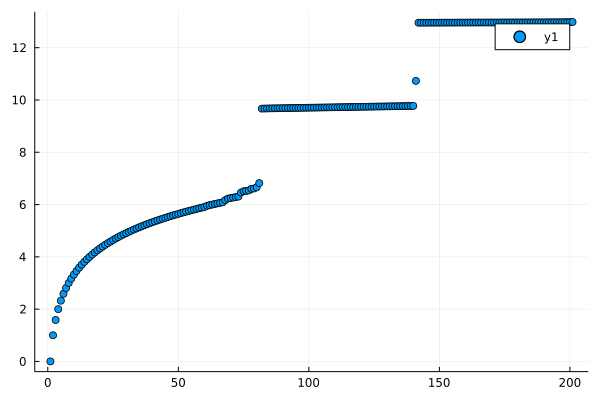

In [30]:
StatsPlots.scatter(log2.(first.(kmer_counts_histogram)))

# Fit error cluster

In [31]:
kmer_depth_of_coverage_bins = log2.(first.(kmer_counts_histogram))

201-element Vector{Float64}:
  0.0
  1.0
  1.584962500721156
  2.0
  2.321928094887362
  2.584962500721156
  2.807354922057604
  3.0
  3.169925001442312
  3.321928094887362
  3.4594316186372973
  3.584962500721156
  3.700439718141092
  ⋮
 12.96974625081451
 12.970465440779995
 12.97100459807343
 12.971902746045467
 12.972261848733291
 12.973159214589735
 12.97333862080036
 12.974593839981678
 12.975489756945754
 12.97656412341533
 12.97692206785108
 12.982637133669424

In [32]:
distance_matrix = zeros((length(kmer_depth_of_coverage_bins), length(kmer_depth_of_coverage_bins)))
for (row, depth_of_coverage_bin_1) in enumerate(kmer_depth_of_coverage_bins)
    for (col, depth_of_coverage_bin_2) in enumerate(kmer_depth_of_coverage_bins)
        distance = abs(depth_of_coverage_bin_1 - depth_of_coverage_bin_2)
        distance_matrix[row, col] = distance
    end
end
distance_matrix

201×201 Matrix{Float64}:
  0.0       1.0        1.58496    2.0       …  12.9769       12.9826
  1.0       0.0        0.584963   1.0          11.9769       11.9826
  1.58496   0.584963   0.0        0.415037     11.392        11.3977
  2.0       1.0        0.415037   0.0          10.9769       10.9826
  2.32193   1.32193    0.736966   0.321928     10.655        10.6607
  2.58496   1.58496    1.0        0.584963  …  10.392        10.3977
  2.80735   1.80735    1.22239    0.807355     10.1696       10.1753
  3.0       2.0        1.41504    1.0           9.97692       9.98264
  3.16993   2.16993    1.58496    1.16993       9.807         9.81271
  3.32193   2.32193    1.73697    1.32193       9.65499       9.66071
  3.45943   2.45943    1.87447    1.45943   …   9.51749       9.52321
  3.58496   2.58496    2.0        1.58496       9.39196       9.39767
  3.70044   2.70044    2.11548    1.70044       9.27648       9.2822
  ⋮                                         ⋱                 ⋮
 12.9697 

In [33]:
# distance_matrix = zeros((length(kmer_counts_histogram), length(kmer_counts_histogram)))
# for (row, kmer_count_pair_1) in enumerate(kmer_counts_histogram)
#     for (col, kmer_count_pair_2) in enumerate(kmer_counts_histogram)
# #         distance = abs(depth_of_coverage_bin_1 - depth_of_coverage_bin_2)
#         distance = Distances.euclidean([kmer_count_pair_1...], [kmer_count_pair_2...])
#         distance_matrix[row, col] = distance
#     end
# end
# distance_matrix

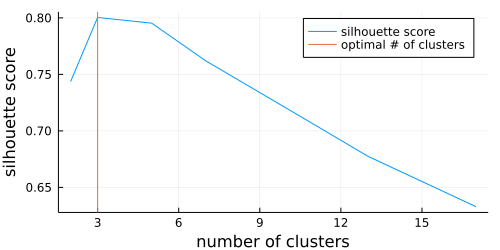

In [99]:
ks = Primes.primes(2, 17)
ys = map(k ->
            Statistics.mean(Statistics.mean(Clustering.silhouettes(Clustering.kmedoids(distance_matrix, k), distance_matrix)) for i in 1:1000),
            ks)

ymax, ymax_index = findmax(ys)

optimal_k = ks[ymax_index]

p = StatsPlots.plot(ks, ys, label="silhouette score", ylabel = "silhouette score", xlabel = "number of clusters", size=(2*scale,scale))
StatsPlots.vline!(p, [optimal_k], label="optimal # of clusters")

In [38]:
clusterings = [Clustering.kmedoids(distance_matrix, optimal_k) for i in 1:10]

max_value, max_value_index = findmax(clustering -> Statistics.mean(Clustering.silhouettes(clustering, distance_matrix)), clusterings)

(0.8683912672179184, 2)

In [39]:
optimal_clustering = clusterings[max_value_index]

Clustering.KmedoidsResult{Float64}([41, 171, 111], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [5.357552004618084, 4.357552004618084, 3.7725895038969277, 3.357552004618084, 3.0356239097307216, 2.7725895038969277, 2.5501970825604796, 2.357552004618084, 2.1876270031757716, 2.0356239097307216  …  0.0070248102580912075, 0.007922958230128785, 0.008282060917952805, 0.00917942677439676, 0.009358832985022048, 0.01061405216633915, 0.011509969130415243, 0.012584335599990837, 0.01294228003574105, 0.01865734585408596], [81, 60, 60], 83.62922813601475, 1, true)

In [40]:
optimal_clustering.assignments

201-element Vector{Int64}:
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 ⋮
 2
 2
 2
 2
 2
 2
 2
 2
 2
 2
 2
 2

In [41]:
min_medoid_value, min_medoid_index = findmin(optimal_clustering.medoids)

(41, 1)

In [42]:
indices_to_include = map(assignment -> assignment .!= min_medoid_index, optimal_clustering.assignments)

201-element Vector{Bool}:
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 ⋮
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1

In [43]:
kmer_depth_of_coverage_bins

201-element Vector{Float64}:
  0.0
  1.0
  1.584962500721156
  2.0
  2.321928094887362
  2.584962500721156
  2.807354922057604
  3.0
  3.169925001442312
  3.321928094887362
  3.4594316186372973
  3.584962500721156
  3.700439718141092
  ⋮
 12.96974625081451
 12.970465440779995
 12.97100459807343
 12.971902746045467
 12.972261848733291
 12.973159214589735
 12.97333862080036
 12.974593839981678
 12.975489756945754
 12.97656412341533
 12.97692206785108
 12.982637133669424

In [87]:
threshold = Int(ceil(2^maximum(kmer_depth_of_coverage_bins[.!indices_to_include]))) + 1

115

In [88]:
groupings = []
for cluster_index in 1:optimal_k
    push!(groupings, kmer_counts_histogram[findall(optimal_clustering.assignments .== cluster_index)])
end

In [89]:
groupings = sort(groupings, by=x->Statistics.median(first.(x)))

3-element Vector{Any}:
 [1 => 34002, 2 => 12999, 3 => 6266, 4 => 3091, 5 => 1871, 6 => 1466, 7 => 1090, 8 => 951, 9 => 961, 10 => 617  …  78 => 1, 79 => 1, 88 => 1, 91 => 3, 92 => 2, 93 => 1, 97 => 1, 98 => 1, 101 => 1, 113 => 1]
 [814 => 1, 816 => 1, 818 => 2, 819 => 7, 820 => 6, 821 => 7, 822 => 5, 823 => 5, 824 => 1, 825 => 9  …  866 => 5, 867 => 2, 868 => 3, 869 => 1, 870 => 2, 871 => 1, 872 => 1, 874 => 1, 875 => 1, 1699 => 1]
 [7942 => 1, 7943 => 1, 7947 => 1, 7948 => 1, 7949 => 1, 7952 => 1, 7953 => 1, 7955 => 2, 7956 => 1, 7957 => 1  …  8029 => 1, 8034 => 1, 8036 => 1, 8041 => 1, 8042 => 1, 8049 => 1, 8054 => 1, 8060 => 1, 8062 => 1, 8094 => 1]

In [90]:
xs = [log2.(first.(x)) for x in groupings]

3-element Vector{Vector{Float64}}:
 [0.0, 1.0, 1.584962500721156, 2.0, 2.321928094887362, 2.584962500721156, 2.807354922057604, 3.0, 3.169925001442312, 3.321928094887362  …  6.285402218862249, 6.303780748177103, 6.459431618637297, 6.507794640198696, 6.523561956057013, 6.539158811108031, 6.599912842187128, 6.614709844115208, 6.658211482751795, 6.820178962415188]
 [9.668884984266247, 9.672425341971495, 9.67595703294175, 9.677719641641009, 9.679480099505446, 9.681238411777805, 9.682994583681683, 9.684748620421626, 9.686500527183219, 9.688250309133178  …  9.758223214726724, 9.759888183221834, 9.761551232444479, 9.7632123668144, 9.76487159073609, 9.766528908598865, 9.768184324776927, 9.7714894695006, 9.77313920671969, 10.73047013718422]
 [12.955286645524469, 12.955468287959821, 12.956194629090778, 12.95637615724967, 12.956557662570523, 12.957102041562287, 12.957283455588415, 12.95764621521841, 12.957827560833744, 12.958008883656943  …  12.97100459807343, 12.971902746045467, 12.9722618487332

In [91]:
ys = [log2.(last.(x)) for x in groupings]

3-element Vector{Vector{Float64}}:
 [15.053331987830681, 13.666113021993025, 12.613329054371054, 11.593857938858223, 10.869593843240784, 10.517669388133811, 10.090112419664289, 9.893301530860564, 9.90839262077375, 9.269126679149418  …  0.0, 0.0, 0.0, 1.584962500721156, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [0.0, 0.0, 1.0, 2.807354922057604, 2.584962500721156, 2.807354922057604, 2.321928094887362, 2.321928094887362, 0.0, 3.169925001442312  …  2.321928094887362, 1.0, 1.584962500721156, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [92]:
labels = reshape(vcat(["sequencing errors"], ["cluster $i" for i in 2:optimal_k]), (1,optimal_k))

1×3 Matrix{String}:
 "sequencing errors"  "cluster 2"  "cluster 3"

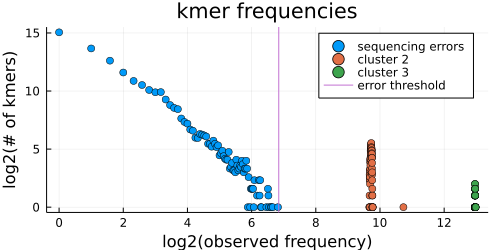

In [93]:
scale = 250
p = StatsPlots.scatter(xs, ys, labels = labels, size=(2scale,scale), title="kmer frequencies", xlabel = "log2(observed frequency)", ylabel = "log2(# of kmers)")

StatsPlots.vline!(p, log2.([threshold]), label="error threshold")

# raw graph

In [ ]:
# # make me faster by counting edges ahead of time
# @time observation_graph = Mycelia.fastx_to_simple_kmer_graph(BioSequences.DNAMer{k}, observations_file)

In [ ]:
# kmer_counts = Dict(observation_graph.vprops[v][:kmer] => observation_graph.vprops[v][:weight] for v in LightGraphs.vertices(observation_graph))
# total_observed_kmers = sum(values(kmer_counts))
# kmer_probabilities = Dict(k => v/total_observed_kmers for (k,v) in kmer_counts)
# scale = 250
# Mycelia.plot_kmer_frequency_spectra(values(kmer_counts), size=(2scale,scale), title="kmer frequencies")

In [ ]:
# reference_kmers = keys(Mycelia.count_canonical_kmers(BioSequences.DNAMer{k}, reference_fasta_file))
# distance_to_reference_graph = 1 - LSHFunctions.jaccard(Set(reference_kmers), Set(keys(kmer_counts)))

In [ ]:
# kmer_counts_histogram = sort(collect(StatsBase.countmap(collect(values(kmer_counts)))), by=x->x[1])

In [ ]:
# # visualize
# gfa_file = observations_file * ".k-$k.gfa"
# Mycelia.graph_to_gfa(observation_graph, gfa_file)

# run(`$(BANDAGE) image $(gfa_file) $(gfa_file).svg --depwidth .9 --deppower .9`)
# # --nodewidth <float> Average node width (0.5 to 1000, default: 5)
# # --depwidth <float>  Depth effect on width (0 to 1, default: 0.5)
# # --deppower <float>  Power of depth effect on width (0 to 1, default: 0.5)

# html_path_to_svg = "./" * repeat("../", length(split(pwd(), '/')) - 3)
# html_path_to_svg *= replace("$(gfa_file).svg", "$(homedir())/" => "")

# x = "<img src=$(html_path_to_svg)>"
# display("text/html", x)
# # display("image/svg+xml", read("$(gfa_file).svg", String))

In [ ]:
# threshold filtered graph

In [ ]:
# make me faster by counting edges ahead of time
@time observation_graph = Mycelia.fastx_to_simple_kmer_graph(BioSequences.DNAMer{k}, observations_file, minimum_coverage=threshold)

In [ ]:
kmer_counts = Dict(observation_graph.vprops[v][:kmer] => observation_graph.vprops[v][:weight] for v in LightGraphs.vertices(observation_graph))
total_observed_kmers = sum(values(kmer_counts))
kmer_probabilities = Dict(k => v/total_observed_kmers for (k,v) in kmer_counts)
scale = 250
Mycelia.plot_kmer_frequency_spectra(values(kmer_counts), size=(2scale,scale), title="kmer frequencies")

In [ ]:
reference_kmers = keys(Mycelia.count_canonical_kmers(BioSequences.DNAMer{k}, reference_fasta_file))
distance_to_reference_graph = 1 - LSHFunctions.jaccard(Set(reference_kmers), Set(keys(kmer_counts)))

In [ ]:
kmer_counts_histogram = sort(collect(StatsBase.countmap(collect(values(kmer_counts)))), by=x->x[1])

In [ ]:
# visualize
gfa_file = observations_file * ".k-$k.gfa"
Mycelia.graph_to_gfa(observation_graph, gfa_file)

run(`$(BANDAGE) image $(gfa_file) $(gfa_file).svg --depwidth .9 --deppower .9`)
# --nodewidth <float> Average node width (0.5 to 1000, default: 5)
# --depwidth <float>  Depth effect on width (0 to 1, default: 0.5)
# --deppower <float>  Power of depth effect on width (0 to 1, default: 0.5)

html_path_to_svg = "./" * repeat("../", length(split(pwd(), '/')) - 3)
html_path_to_svg *= replace("$(gfa_file).svg", "$(homedir())/" => "")

x = "<img src=$(html_path_to_svg)>"
display("text/html", x)
# display("image/svg+xml", read("$(gfa_file).svg", String))

In [ ]:
# this didn't work because it uses longer minimizers than the kmers were set to?
# run(`GraphAligner -g $(gfa_file) -f $(observations_file) -a $(observations_file).gaf -x dbg`)

In [ ]:
# try again using simplified graph

In [ ]:
simplified_graph = Mycelia.simplify_kmer_graph(observation_graph)

In [ ]:
# write simplified graph to gfa
# visualize
gfa_file = observations_file * ".k-$k.simplified.gfa"
Mycelia.graph_to_gfa(simplified_graph, gfa_file)

run(`$(BANDAGE) image $(gfa_file) $(gfa_file).svg --depwidth .9 --deppower .9`)
# --nodewidth <float> Average node width (0.5 to 1000, default: 5)
# --depwidth <float>  Depth effect on width (0 to 1, default: 0.5)
# --deppower <float>  Power of depth effect on width (0 to 1, default: 0.5)

html_path_to_svg = "./" * repeat("../", length(split(pwd(), '/')) - 3)
html_path_to_svg *= replace("$(gfa_file).svg", "$(homedir())/" => "")

x = "<img src=$(html_path_to_svg)>"
display("text/html", x)
# display("image/svg+xml", read("$(gfa_file).svg", String))

In [ ]:
run(`GraphAligner -g $(gfa_file) -f $(observations_file) -a $(observations_file).gaf -x vg`)

In [ ]:
alignments_file = "$(observations_file).gaf"

In [ ]:
# conda install -c conda-forge -c bioconda bcalm

In [ ]:
line = readline(alignments_file)

In [ ]:
split(line, '\t')

In [ ]:

# first(uCSV.read(alignments_file, delim='\t'))

In [ ]:
# https://github.com/lh3/gfatools/blob/master/doc/rGFA.md#the-graph-alignment-format-gaf
# Query sequence name
# Query sequence length
# Query start (0-based; closed)
# Query end (0-based; open)
# Strand relative to the path: "+" or "-"
# Path matching /([><][^\s><]+(:\d+-\d+)?)+|([^\s><]+)/
# Path length
# Start position on the path (0-based)
# End position on the path (0-based)
# Number of residue matches
# Alignment block length
# Mapping quality (0-255; 255 for missing)
#  "NM:i:0"
#  "AS:f:100"
#  "dv:f:0"
#  "id:f:1"
#  "cg:Z:100="

header = [
    "Query sequence name",
    "Query sequence length",
    "Query start (0-based; closed)",
    "Query end (0-based; open)",
    "Strand",
    "Path",
    "Path length",
    "Start position on the path (0-based)",
    "End position on the path (0-based)",
    "Number of residue matches",
    "Alignment block length",
    "Mapping quality (0-255; 255 for missing)",
    "NM",
    "AS",
    "dv",
    "id",
    "cg"
    ]
mapping_results = DataFrames.DataFrame(first(uCSV.read(alignments_file, delim='\t')), header)

In [ ]:
# take only the first entry for each read
mapping_results = DataFrames.DataFrame([g[1, :] for g in DataFrames.groupby(mapping_results, "Query sequence name")])

In [ ]:
corrected_observations_file = replace(observations_file, ".fastq" => ".k$(k).fasta")

In [ ]:
open(corrected_observations_file, "w") do io
    fastx_io = FASTX.FASTA.Writer(io)
    for mapping_result in DataFrames.eachrow(mapping_results[10:20, :])
#         @show mapping_result["Path"]
        steps = split(replace(mapping_result["Path"], r"(>|<)" => s" \1"))
#         @show steps
        oriented_steps = [(vertex = parse(Int, replace(step, r">|<" => "")), orientation = first(step) == '>' ? true : false) for step in steps]
#         @show oriented_steps
        path_sequences = BioSequences.LongDNASeq[]
        for step in oriented_steps
            seq = simplified_graph.vprops[step.vertex][:sequence]
            if !step.orientation
                seq = BioSequences.reverse_complement(seq)
            end
            push!(path_sequences, seq)
        end
#         @show path_sequences
        path_sequence = reduce(*, path_sequences)
#         @show path_sequence
        if mapping_result["Strand"] == "-"
            path_sequence = BioSequences.reverse_complement(path_sequence)
#             @show "flipping orientation"
        end

        start = mapping_result["Start position on the path (0-based)"] + 1
        stop = mapping_result["End position on the path (0-based)"]
#         @show "extracting $(start):$(stop)"
        path_replacement = path_sequence[start:stop]
#         @show path_replacement
        
        sequence_hash = string(hash(path_replacement))
        barcode_id = string(hash(Dates.now(), hash(Random.randstring(32))))
        record_identifier = "$(sequence_hash)-$(barcode_id)"

        record = FASTX.FASTA.Record(
            record_identifier,
            mapping_result["Query sequence name"],
            path_replacement
        )
#         @show record
        write(fastx_io, record)
    end
    close(fastx_io)
end

In [ ]:
corrected_observation_graph = Mycelia.fastx_to_kmer_graph(BioSequences.DNAMer{k}, corrected_observations_file)

In [ ]:
# visualize
gfa_file = corrected_observations_file * ".k-$k.gfa"
Mycelia.graph_to_gfa(corrected_observation_graph, gfa_file)

run(`$(BANDAGE) image $(gfa_file) $(gfa_file).svg --depwidth .9 --deppower .9`)
# --nodewidth <float> Average node width (0.5 to 1000, default: 5)
# --depwidth <float>  Depth effect on width (0 to 1, default: 0.5)
# --deppower <float>  Power of depth effect on width (0 to 1, default: 0.5)

html_path_to_svg = "./" * repeat("../", length(split(pwd(), '/')) - 3)
html_path_to_svg *= replace("$(gfa_file).svg", "$(homedir())/" => "")

x = "<img src=$(html_path_to_svg)>"
display("text/html", x)
# display("image/svg+xml", read("$(gfa_file).svg", String))

In [ ]:
kmer_counts = Dict(corrected_observation_graph.vprops[v][:kmer] => corrected_observation_graph.vprops[v][:weight] for v in LightGraphs.vertices(corrected_observation_graph))
total_observed_kmers = sum(values(kmer_counts))
kmer_probabilities = Dict(k => v/total_observed_kmers for (k,v) in kmer_counts)
scale = 250
Mycelia.plot_kmer_frequency_spectra(values(kmer_counts), size=(2scale,scale), title="kmer frequencies")

In [ ]:
# compare the new graph to the error-free graph to the error-corrected graph

In [ ]:
reference_kmers = keys(Mycelia.count_canonical_kmers(BioSequences.DNAMer{k}, reference_fasta_file))
distance_to_reference_graph = 1 - LSHFunctions.jaccard(Set(reference_kmers), Set(keys(kmer_counts)))

# repeat with iterative k

In [ ]:
k = k_options[k_index]

In [ ]:
k = k_options[findfirst(new_k -> new_k > k, k_options)]

In [ ]:
observations_file = corrected_observations_file

In [ ]:
kmer_counts = Mycelia.count_canonical_kmers(BioSequences.DNAMer{k}, observations_file)

In [ ]:
kmer_counts_histogram = sort(collect(StatsBase.countmap(values(kmer_counts))), by=x->x[1])

In [ ]:
scale = 250
Mycelia.plot_kmer_frequency_spectra(values(kmer_counts), size=(2scale,scale), log_scale=log2, title="kmer frequencies")

In [ ]:
StatsPlots.scatter(log2.(first.(kmer_counts_histogram)))

# Fit error cluster

In [ ]:
kmer_depth_of_coverage_bins = log2.(first.(kmer_counts_histogram))

In [ ]:
distance_matrix = zeros((length(kmer_depth_of_coverage_bins), length(kmer_depth_of_coverage_bins)))
for (row, depth_of_coverage_bin_1) in enumerate(kmer_depth_of_coverage_bins)
    for (col, depth_of_coverage_bin_2) in enumerate(kmer_depth_of_coverage_bins)
        distance = abs(depth_of_coverage_bin_1 - depth_of_coverage_bin_2)
        distance_matrix[row, col] = distance
    end
end
distance_matrix

In [ ]:
# distance_matrix = zeros((length(kmer_counts_histogram), length(kmer_counts_histogram)))
# for (row, kmer_count_pair_1) in enumerate(kmer_counts_histogram)
#     for (col, kmer_count_pair_2) in enumerate(kmer_counts_histogram)
# #         distance = abs(depth_of_coverage_bin_1 - depth_of_coverage_bin_2)
#         distance = Distances.euclidean([kmer_count_pair_1...], [kmer_count_pair_2...])
#         distance_matrix[row, col] = distance
#     end
# end
# distance_matrix

In [ ]:
max_kmedoids_k = min(length(kmer_depth_of_coverage_bins), 7)
ks = Primes.primes(2, max_kmedoids_k)
ys = map(k ->
            Statistics.mean(Statistics.mean(Clustering.silhouettes(Clustering.kmedoids(distance_matrix, k), distance_matrix)) for i in 1:100),
            ks)

In [ ]:
StatsPlots.plot(ks, ys, label="silhouette score", ylabel = "silhouette score", xlabel = "number of clusters")

In [ ]:
ymax, ymax_index = findmax(ys)

In [ ]:
optimal_k = ks[ymax_index]

In [ ]:
clusterings = [Clustering.kmedoids(distance_matrix, optimal_k) for i in 1:10]

max_value, max_value_index = findmax(clustering -> Statistics.mean(Clustering.silhouettes(clustering, distance_matrix)), clusterings)

In [ ]:
optimal_clustering = clusterings[max_value_index]

In [ ]:
optimal_clustering.assignments

In [ ]:
min_medoid_value, min_medoid_index = findmin(optimal_clustering.medoids)

In [ ]:
indices_to_include = map(assignment -> assignment .!= min_medoid_index, optimal_clustering.assignments)

In [ ]:
kmer_depth_of_coverage_bins

In [ ]:
threshold = Int(ceil(2^maximum(kmer_depth_of_coverage_bins[.!indices_to_include]))) + 1

In [ ]:
scale = 250
p = Mycelia.plot_kmer_frequency_spectra(values(kmer_counts), log_scale = log2, size=(2scale,scale), title="kmer frequencies")
StatsPlots.vline!(p, log2.([threshold]))

# raw graph

In [ ]:
# # make me faster by counting edges ahead of time
# @time observation_graph = Mycelia.fastx_to_simple_kmer_graph(BioSequences.DNAMer{k}, observations_file)

In [ ]:
# kmer_counts = Dict(observation_graph.vprops[v][:kmer] => observation_graph.vprops[v][:weight] for v in LightGraphs.vertices(observation_graph))
# total_observed_kmers = sum(values(kmer_counts))
# kmer_probabilities = Dict(k => v/total_observed_kmers for (k,v) in kmer_counts)
# scale = 250
# Mycelia.plot_kmer_frequency_spectra(values(kmer_counts), size=(2scale,scale), title="kmer frequencies")

In [ ]:
# reference_kmers = keys(Mycelia.count_canonical_kmers(BioSequences.DNAMer{k}, reference_fasta_file))
# distance_to_reference_graph = 1 - LSHFunctions.jaccard(Set(reference_kmers), Set(keys(kmer_counts)))

In [ ]:
# kmer_counts_histogram = sort(collect(StatsBase.countmap(collect(values(kmer_counts)))), by=x->x[1])

In [ ]:
# # visualize
# gfa_file = observations_file * ".k-$k.gfa"
# Mycelia.graph_to_gfa(observation_graph, gfa_file)

# run(`$(BANDAGE) image $(gfa_file) $(gfa_file).svg --depwidth .9 --deppower .9`)
# # --nodewidth <float> Average node width (0.5 to 1000, default: 5)
# # --depwidth <float>  Depth effect on width (0 to 1, default: 0.5)
# # --deppower <float>  Power of depth effect on width (0 to 1, default: 0.5)

# html_path_to_svg = "./" * repeat("../", length(split(pwd(), '/')) - 3)
# html_path_to_svg *= replace("$(gfa_file).svg", "$(homedir())/" => "")

# x = "<img src=$(html_path_to_svg)>"
# display("text/html", x)
# # display("image/svg+xml", read("$(gfa_file).svg", String))

In [ ]:
# threshold filtered graph

In [ ]:
# make me faster by counting edges ahead of time
@time observation_graph = Mycelia.fastx_to_simple_kmer_graph(BioSequences.DNAMer{k}, observations_file, minimum_coverage=1)

In [ ]:
kmer_counts = Dict(observation_graph.vprops[v][:kmer] => observation_graph.vprops[v][:weight] for v in LightGraphs.vertices(observation_graph))
total_observed_kmers = sum(values(kmer_counts))
kmer_probabilities = Dict(k => v/total_observed_kmers for (k,v) in kmer_counts)
scale = 250
Mycelia.plot_kmer_frequency_spectra(values(kmer_counts), size=(2scale,scale), title="kmer frequencies")

In [ ]:
reference_kmers = keys(Mycelia.count_canonical_kmers(BioSequences.DNAMer{k}, reference_fasta_file))
distance_to_reference_graph = 1 - LSHFunctions.jaccard(Set(reference_kmers), Set(keys(kmer_counts)))

In [ ]:
kmer_counts_histogram = sort(collect(StatsBase.countmap(collect(values(kmer_counts)))), by=x->x[1])

In [ ]:
# visualize
gfa_file = observations_file * ".k-$k.gfa"
Mycelia.graph_to_gfa(observation_graph, gfa_file)

run(`$(BANDAGE) image $(gfa_file) $(gfa_file).svg --depwidth .9 --deppower .9`)
# --nodewidth <float> Average node width (0.5 to 1000, default: 5)
# --depwidth <float>  Depth effect on width (0 to 1, default: 0.5)
# --deppower <float>  Power of depth effect on width (0 to 1, default: 0.5)

html_path_to_svg = "./" * repeat("../", length(split(pwd(), '/')) - 3)
html_path_to_svg *= replace("$(gfa_file).svg", "$(homedir())/" => "")

x = "<img src=$(html_path_to_svg)>"
display("text/html", x)
# display("image/svg+xml", read("$(gfa_file).svg", String))

In [ ]:
# this didn't work because it uses longer minimizers than the kmers were set to?
# run(`GraphAligner -g $(gfa_file) -f $(observations_file) -a $(observations_file).gaf -x dbg`)

In [ ]:
# try again using simplified graph

In [ ]:
simplified_graph = Mycelia.simplify_kmer_graph(observation_graph)

In [ ]:
# write simplified graph to gfa
# visualize
gfa_file = observations_file * ".k-$k.simplified.gfa"
Mycelia.graph_to_gfa(simplified_graph, gfa_file)

run(`$(BANDAGE) image $(gfa_file) $(gfa_file).svg --depwidth .9 --deppower .9`)
# --nodewidth <float> Average node width (0.5 to 1000, default: 5)
# --depwidth <float>  Depth effect on width (0 to 1, default: 0.5)
# --deppower <float>  Power of depth effect on width (0 to 1, default: 0.5)

html_path_to_svg = "./" * repeat("../", length(split(pwd(), '/')) - 3)
html_path_to_svg *= replace("$(gfa_file).svg", "$(homedir())/" => "")

x = "<img src=$(html_path_to_svg)>"
display("text/html", x)
# display("image/svg+xml", read("$(gfa_file).svg", String))

In [ ]:
run(`GraphAligner -g $(gfa_file) -f $(observations_file) -a $(observations_file).gaf -x vg`)

In [ ]:
alignments_file = "$(observations_file).gaf"

In [ ]:
# conda install -c conda-forge -c bioconda bcalm

In [ ]:
line = readline(alignments_file)

In [ ]:
split(line, '\t')

In [ ]:

# first(uCSV.read(alignments_file, delim='\t'))

In [ ]:
# https://github.com/lh3/gfatools/blob/master/doc/rGFA.md#the-graph-alignment-format-gaf
# Query sequence name
# Query sequence length
# Query start (0-based; closed)
# Query end (0-based; open)
# Strand relative to the path: "+" or "-"
# Path matching /([><][^\s><]+(:\d+-\d+)?)+|([^\s><]+)/
# Path length
# Start position on the path (0-based)
# End position on the path (0-based)
# Number of residue matches
# Alignment block length
# Mapping quality (0-255; 255 for missing)
#  "NM:i:0"
#  "AS:f:100"
#  "dv:f:0"
#  "id:f:1"
#  "cg:Z:100="

header = [
    "Query sequence name",
    "Query sequence length",
    "Query start (0-based; closed)",
    "Query end (0-based; open)",
    "Strand",
    "Path",
    "Path length",
    "Start position on the path (0-based)",
    "End position on the path (0-based)",
    "Number of residue matches",
    "Alignment block length",
    "Mapping quality (0-255; 255 for missing)",
    "NM",
    "AS",
    "dv",
    "id",
    "cg"
    ]
mapping_results = DataFrames.DataFrame(first(uCSV.read(alignments_file, delim='\t')), header)

In [ ]:
# take only the first entry for each read
mapping_results = DataFrames.DataFrame([g[1, :] for g in DataFrames.groupby(mapping_results, "Query sequence name")])

In [ ]:
corrected_observations_file = replace(observations_file, ".fastq" => ".k$(k).fasta")

In [ ]:
open(corrected_observations_file, "w") do io
    fastx_io = FASTX.FASTA.Writer(io)
    for mapping_result in DataFrames.eachrow(mapping_results[10:20, :])
#         @show mapping_result["Path"]
        steps = split(replace(mapping_result["Path"], r"(>|<)" => s" \1"))
#         @show steps
        oriented_steps = [(vertex = parse(Int, replace(step, r">|<" => "")), orientation = first(step) == '>' ? true : false) for step in steps]
#         @show oriented_steps
        path_sequences = BioSequences.LongDNASeq[]
        for step in oriented_steps
            seq = simplified_graph.vprops[step.vertex][:sequence]
            if !step.orientation
                seq = BioSequences.reverse_complement(seq)
            end
            push!(path_sequences, seq)
        end
#         @show path_sequences
        path_sequence = reduce(*, path_sequences)
#         @show path_sequence
        if mapping_result["Strand"] == "-"
            path_sequence = BioSequences.reverse_complement(path_sequence)
#             @show "flipping orientation"
        end

        start = mapping_result["Start position on the path (0-based)"] + 1
        stop = mapping_result["End position on the path (0-based)"]
#         @show "extracting $(start):$(stop)"
        path_replacement = path_sequence[start:stop]
#         @show path_replacement
        
        sequence_hash = string(hash(path_replacement))
        barcode_id = string(hash(Dates.now(), hash(Random.randstring(32))))
        record_identifier = "$(sequence_hash)-$(barcode_id)"

        record = FASTX.FASTA.Record(
            record_identifier,
            mapping_result["Query sequence name"],
            path_replacement
        )
#         @show record
        write(fastx_io, record)
    end
    close(fastx_io)
end

In [ ]:
corrected_observation_graph = Mycelia.fastx_to_kmer_graph(BioSequences.DNAMer{k}, corrected_observations_file)

In [ ]:
# visualize
gfa_file = corrected_observations_file * ".k-$k.gfa"
Mycelia.graph_to_gfa(corrected_observation_graph, gfa_file)

run(`$(BANDAGE) image $(gfa_file) $(gfa_file).svg --depwidth .9 --deppower .9`)
# --nodewidth <float> Average node width (0.5 to 1000, default: 5)
# --depwidth <float>  Depth effect on width (0 to 1, default: 0.5)
# --deppower <float>  Power of depth effect on width (0 to 1, default: 0.5)

html_path_to_svg = "./" * repeat("../", length(split(pwd(), '/')) - 3)
html_path_to_svg *= replace("$(gfa_file).svg", "$(homedir())/" => "")

x = "<img src=$(html_path_to_svg)>"
display("text/html", x)
# display("image/svg+xml", read("$(gfa_file).svg", String))

In [ ]:
kmer_counts = Dict(corrected_observation_graph.vprops[v][:kmer] => corrected_observation_graph.vprops[v][:weight] for v in LightGraphs.vertices(corrected_observation_graph))
total_observed_kmers = sum(values(kmer_counts))
kmer_probabilities = Dict(k => v/total_observed_kmers for (k,v) in kmer_counts)
scale = 250
Mycelia.plot_kmer_frequency_spectra(values(kmer_counts), size=(2scale,scale), title="kmer frequencies")

In [ ]:
# compare the new graph to the error-free graph to the error-corrected graph

In [ ]:
reference_kmers = keys(Mycelia.count_canonical_kmers(BioSequences.DNAMer{k}, reference_fasta_file))
distance_to_reference_graph = 1 - LSHFunctions.jaccard(Set(reference_kmers), Set(keys(kmer_counts)))